# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from feature_engine.creation import CyclicalFeatures

In [46]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

<Axes: xlabel='week'>

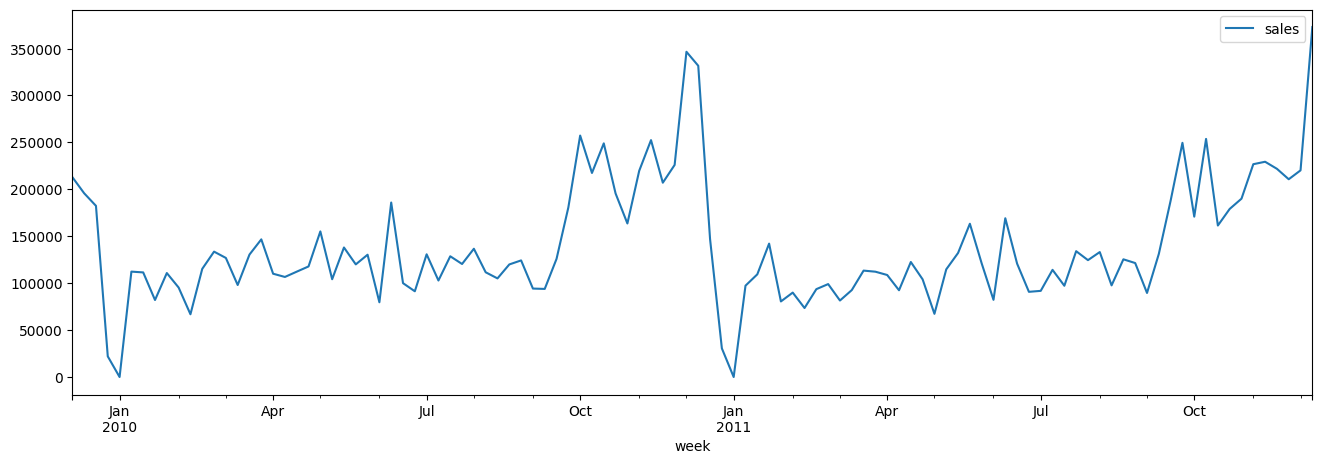

In [4]:
df.plot(figsize=(16, 5))

Check what is the frequency of adjacent timestamps:

In [15]:
(df.index[1:] - df.index[:-1]).value_counts()

7 days    105
Name: week, dtype: int64

Here it seems, that we see we have a timestamp every 7 days.

## Missing data

Check if there are missing values in the time series.

In [17]:
df.isnull().sum()

sales    0
dtype: int64

There are no missing data points.

## Missing timestamps

Check if there are missing timestamps in the index.

In [18]:
df.index.isnull().sum()

0

As well we cannot find any missing timestamps.

## Seasonality

Does the time series show any obvious seasonal pattern?

Text(0.5, 1.0, 'Monthly sales aggregated')

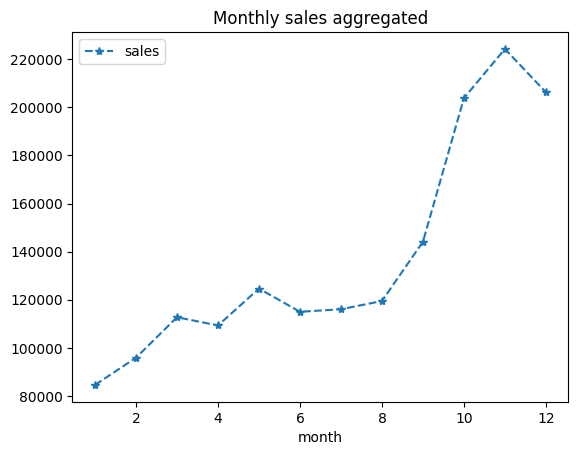

In [47]:
ax = df.assign(month=df.index.month).groupby("month").mean().plot(linestyle="--", marker="*")
ax.set_title("Monthly sales aggregated")

- Sales seem to be the lowest in January and the highest in November
- September to December are the month with the highest sales

<Axes: xlabel='month', ylabel='sales'>

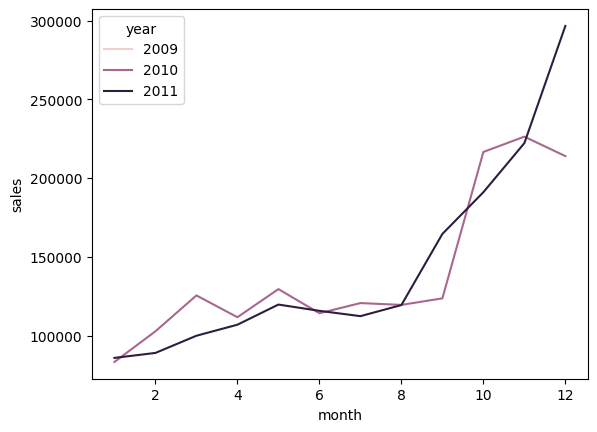

In [48]:
sns.lineplot(
    data=(
        df
        .assign(month=df.index.month, year=df.index.year)
        .groupby(["month", "year"])
        .mean()
        .reset_index()
    ),
    x="month", y="sales", hue="year"
)


- Seasonality pattern seems to be stable over the years
- But we only have two years here

/var/folders/y0/hcsvz82s1mq0btvh4lmpn2600000gp/T/ipykernel_51590/150552366.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df.assign(woy=df.index.weekofyear).groupby("woy").mean().plot()


<Axes: xlabel='woy'>

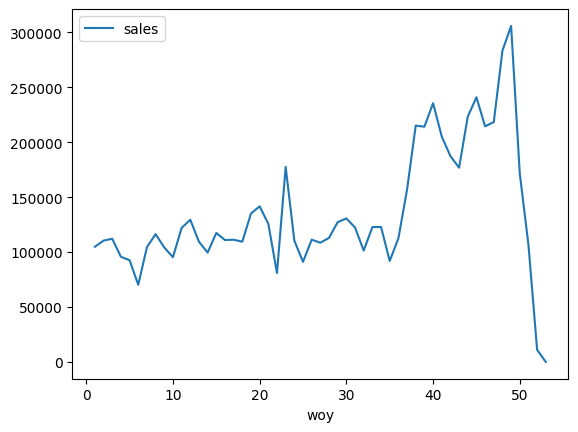

In [50]:
df.assign(woy=df.index.weekofyear).groupby("woy").mean().plot()

In [55]:
df.assign(woy=df.index.weekofyear).groupby("woy").mean().sort_values(by="sales", ascending=False).head(15)

/var/folders/y0/hcsvz82s1mq0btvh4lmpn2600000gp/T/ipykernel_51590/4092068077.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df.assign(woy=df.index.weekofyear).groupby("woy").mean().sort_values(by="sales", ascending=False).head(15)


,sales
woy,
49,305869.113333
48,283396.315000
45,240903.470500
40,235578.235000
44,223251.260000
47,218368.430000
38,215121.095500
46,214464.380500
39,214102.750500


- There might be also a peak around the 23rd week
- perhaps a pre-summer sale

# Feature engineering

Now, let's begin to tabularize the data.

## Time based features

- We see that the month is an important factor influencing the sales -> we should model it as a feature

In [125]:
df_feat = df.copy()

# If the month is encoded as simple integer, we should consider it as categorical variable
df_feat = df_feat.assign(woy=df_feat.index.weekofyear, month=df_feat.index.month)
df_feat.rename({"month": "month_cat", "woy": "woy_cat"}, inplace=True, axis=1)

cat_time_vars = ["month_cat", "woy_cat"]

df_feat.head()

/var/folders/y0/hcsvz82s1mq0btvh4lmpn2600000gp/T/ipykernel_51590/975611719.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_feat = df_feat.assign(woy=df_feat.index.weekofyear, month=df_feat.index.month)


,sales,woy_cat,month_cat
week,,,
2009-12-06,213000.35,49,12
2009-12-13,195810.04,50,12
2009-12-20,182396.74,51,12
2009-12-27,22007.77,52,12
2010-01-03,0.00,53,1


For models which do not handle categorical variables well / natively, such as linear regression, we can encode the time based features using sine and cosine encodings

In [126]:
df_feat = CyclicalFeatures(variables=cat_time_vars, drop_original=False).fit_transform(df_feat)

cont_time_vars = ["month_con_sin", "month_con_cos", "woy_con_sin", "woy_con_cos"]

df_feat.rename(
    {f"{k}_{f}": f"{k}_{f}".replace("cat", "con") for k, f in it.product(cat_time_vars, ["sin", "cos"])},
    axis=1, inplace=True
)

df_feat.head()

,sales,woy_cat,month_cat,month_con_sin,month_con_cos,woy_con_sin,woy_con_cos
week,,,,,,,
2009-12-06,213000.35,49,12,-2.449294e-16,1.000000,-4.566292e-01,0.889657
2009-12-13,195810.04,50,12,-2.449294e-16,1.000000,-3.482016e-01,0.937420
2009-12-20,182396.74,51,12,-2.449294e-16,1.000000,-2.348860e-01,0.972023
2009-12-27,22007.77,52,12,-2.449294e-16,1.000000,-1.182732e-01,0.992981
2010-01-03,0.00,53,1,5.000000e-01,0.866025,-2.449294e-16,1.000000


## Lag based features

- Sales from one, two and four weeks ago might be good features

In [127]:
lags = ["1w", "2w", "4w"]
lag_vars = []

for lag in lags:
    # Name of the lag feature
    lag_vars.append(f"sales_lag{lag}")

    df_feat = (
        df_feat
        # Add lag of 1 week
        .merge(
            (
                df_feat[["sales"]]
                .shift(freq=lag)
                .rename({"sales": lag_vars[-1]}, axis=1)
            ),
            left_index=True, right_index=True, how="left"
        )
    )

df_feat.head()

,sales,woy_cat,month_cat,month_con_sin,month_con_cos,woy_con_sin,woy_con_cos,sales_lag1w,sales_lag2w,sales_lag4w
week,,,,,,,,,,
2009-12-06,213000.35,49,12,-2.449294e-16,1.000000,-4.566292e-01,0.889657,NaN,NaN,NaN
2009-12-13,195810.04,50,12,-2.449294e-16,1.000000,-3.482016e-01,0.937420,213000.35,NaN,NaN
2009-12-20,182396.74,51,12,-2.449294e-16,1.000000,-2.348860e-01,0.972023,195810.04,213000.35,NaN
2009-12-27,22007.77,52,12,-2.449294e-16,1.000000,-1.182732e-01,0.992981,182396.74,195810.04,NaN
2010-01-03,0.00,53,1,5.000000e-01,0.866025,-2.449294e-16,1.000000,22007.77,182396.74,213000.35


## Window based features

In [128]:
agg_funs = ["mean", "max", "min"]
wins = [2, 4]
win_vars = []

for af, win in it.product(agg_funs, wins):
    # Name of the window feature
    win_vars.append(f"sales_win{win}_{af}")

    df_feat = (
        df_feat
        .merge(
            (
                df_feat[["sales"]]
                .rolling(window=win)
                .agg(af)
                .shift(freq="1w")
                .rename({"sales": win_vars[-1]}, axis=1)
            ),
            left_index=True, right_index=True, how="left"
        )
    )

df_feat.head()

,sales,woy_cat,month_cat,month_con_sin,month_con_cos,woy_con_sin,woy_con_cos,sales_lag1w,sales_lag2w,sales_lag4w,sales_win2_mean,sales_win4_mean,sales_win2_max,sales_win4_max,sales_win2_min,sales_win4_min
week,,,,,,,,,,,,,,,,
2009-12-06,213000.35,49,12,-2.449294e-16,1.000000,-4.566292e-01,0.889657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,195810.04,50,12,-2.449294e-16,1.000000,-3.482016e-01,0.937420,213000.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-20,182396.74,51,12,-2.449294e-16,1.000000,-2.348860e-01,0.972023,195810.04,213000.35,NaN,204405.195,NaN,213000.35,NaN,195810.04,NaN
2009-12-27,22007.77,52,12,-2.449294e-16,1.000000,-1.182732e-01,0.992981,182396.74,195810.04,NaN,189103.390,NaN,195810.04,NaN,182396.74,NaN
2010-01-03,0.00,53,1,5.000000e-01,0.866025,-2.449294e-16,1.000000,22007.77,182396.74,213000.35,102202.255,153303.725,182396.74,213000.35,22007.77,22007.77


No we remove all data points where we do not have sufficent data for training (NaNs)

In [129]:
df_feat.dropna(inplace=True)
df_feat.head()

,sales,woy_cat,month_cat,month_con_sin,month_con_cos,woy_con_sin,woy_con_cos,sales_lag1w,sales_lag2w,sales_lag4w,sales_win2_mean,sales_win4_mean,sales_win2_max,sales_win4_max,sales_win2_min,sales_win4_min
week,,,,,,,,,,,,,,,,
2010-01-03,0.000,53,1,0.5,0.866025,-2.449294e-16,1.000000,22007.770,182396.74,213000.35,102202.2550,153303.72500,182396.74,213000.35,22007.770,22007.77
2010-01-10,112318.850,1,1,0.5,0.866025,1.182732e-01,0.992981,0.000,22007.77,195810.04,11003.8850,100053.63750,22007.77,195810.04,0.000,0.00
2010-01-17,111460.470,2,1,0.5,0.866025,2.348860e-01,0.972023,112318.850,0.00,182396.74,56159.4250,79180.84000,112318.85,182396.74,0.000,0.00
2010-01-24,82065.331,3,1,0.5,0.866025,3.482016e-01,0.937420,111460.470,112318.85,22007.77,111889.6600,61446.77250,112318.85,112318.85,111460.470,0.00
2010-01-31,110790.591,4,1,0.5,0.866025,4.566292e-01,0.889657,82065.331,111460.47,0.00,96762.9005,76461.16275,111460.47,112318.85,82065.331,0.00


## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [130]:
df_feat_train = df_feat[df_feat.index < "2011-10-01"].copy()
df_feat_test = df_feat[df_feat.index >= "2011-10-01"].copy()
print(df_feat_train.shape, df_feat_train.index.max())
print(df_feat_test.shape, df_feat_test.index.min())

(91, 16) 2011-09-25 00:00:00
(11, 16) 2011-10-02 00:00:00


In [132]:
X_train = df_feat_train[cat_time_vars + cont_time_vars + lag_vars + win_vars].copy()
X_test = df_feat_test[cat_time_vars + cont_time_vars + lag_vars + win_vars].copy()

y_train = df_feat_train[["sales"]].copy()
y_test = df_feat_test[["sales"]].copy()

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

RMSE, train: 45844.30745262792
RMSE, test: 65327.34284108387


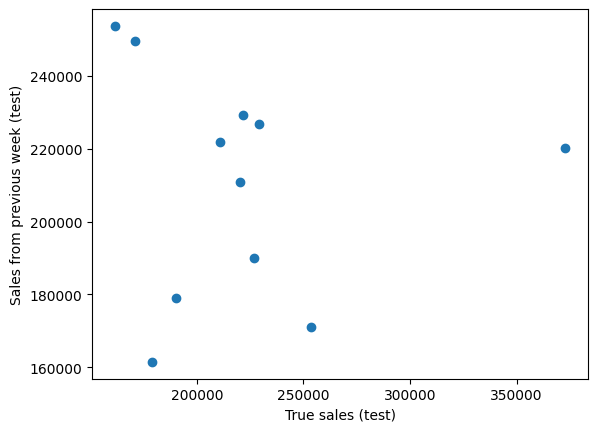

In [154]:
from sklearn.metrics import mean_squared_error

plt.scatter(y_test, X_test["sales_lag1w"])
plt.xlabel("True sales (test)")
plt.ylabel("Sales from previous week (test)")

print("RMSE, train:", mean_squared_error(X_train["sales_lag1w"], y_train, squared=False))
print("RMSE, test:", mean_squared_error(X_test["sales_lag1w"], y_test, squared=False))

## Machine Learning

## Random Forest

RMSE, train: 18215.077154759587
RMSE, test: 45884.90413056339


Text(0, 0.5, 'Predicted sales (test)')

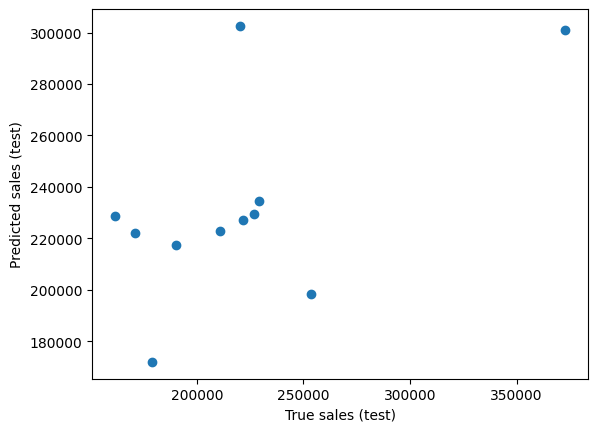

In [153]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_jobs=8, random_state=102, ).fit(X_train, y_train.values.flatten())

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

print("RMSE, train:", mean_squared_error(y_train_pred, y_train, squared=False))
print("RMSE, test:", mean_squared_error(y_test_pred, y_test, squared=False))

plt.scatter(y_test, y_test_pred)
plt.xlabel("True sales (test)")
plt.ylabel("Predicted sales (test)")

Text(0, 0.5, 'Importance')

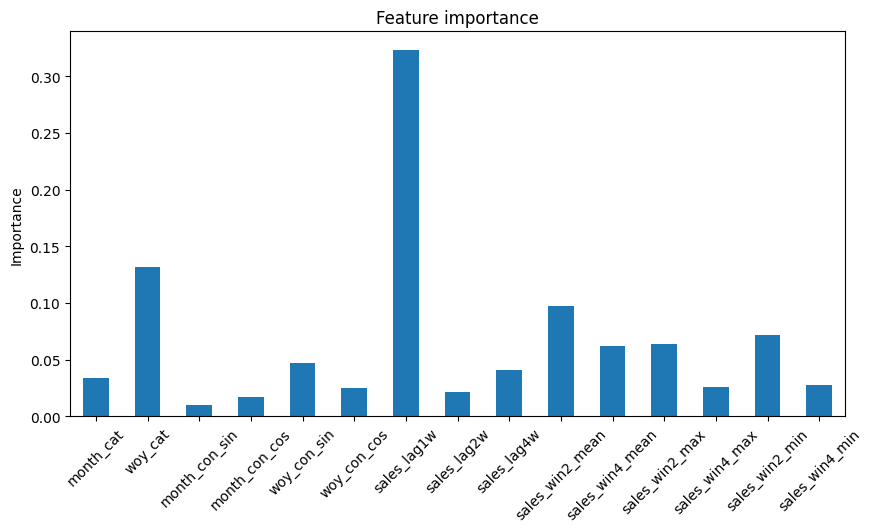

In [155]:
# Create series with feature importance.
tmp = pd.Series(rf_model.feature_importances_)

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")

## Sparse linear model

RMSE, train: 34541.31235396984
RMSE, test: 54171.8595476698


/Users/bach/.miniconda3/envs/feat-eng-ts/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.651e+10, tolerance: 2.932e+07
  model = cd_fast.enet_coordinate_descent(


Text(0, 0.5, 'Predicted sales (test)')

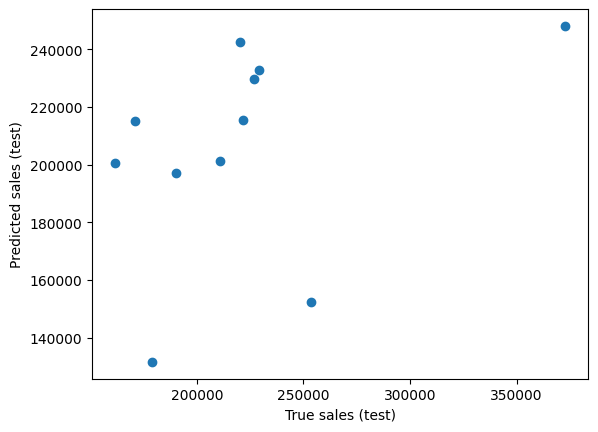

In [310]:
from sklearn.linear_model import LassoCV, Lasso, Ridge, RidgeCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline


# lasso_model = LassoCV(n_alphas=100, random_state=10, cv=TimeSeriesSplit(test_size=12), n_jobs=8).fit(X_train, y_train.values.flatten())
# print("Regularisation:", lasso_model.alpha_)
lasso_model = Lasso(alpha=100, random_state=0).fit(X_train, y_train.values.flatten())

y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

print("RMSE, train:", mean_squared_error(y_train_pred, y_train, squared=False))
print("RMSE, test:", mean_squared_error(y_test_pred, y_test, squared=False))

plt.scatter(y_test, y_test_pred)
plt.xlabel("True sales (test)")
plt.ylabel("Predicted sales (test)")

Text(0, 0.5, 'Importance')

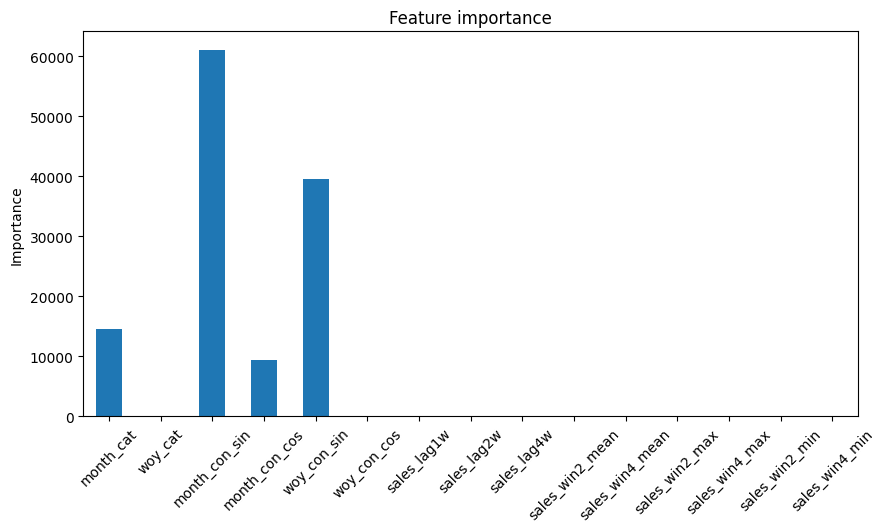

In [268]:
# Create series with feature importance.
tmp = pd.Series(abs(lasso_model.coef_.flatten()))

# Let's add the variable names.
tmp.index = X_train.columns
# Let's make a bar plot.
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")

Try some feature scaling

In [322]:
# Scale sales features to range [-1, 1]
sales_scaler = StandardScaler().fit(y_train.values)
y_train_scaled = sales_scaler.transform(y_train)
y_test_scaled = sales_scaler.transform(y_test)

# Lag and window features are derived from sales as well. Therefore I scale them using the same scaling function
X_train_scaled = X_train[lag_vars + win_vars + cont_time_vars + cat_time_vars].copy()
X_test_scaled = X_test[lag_vars + win_vars + cont_time_vars + cat_time_vars].copy()
for var in lag_vars + win_vars + cont_time_vars:
    X_train_scaled[var] = sales_scaler.transform(X_train_scaled[[var]])
    X_test_scaled[var] = sales_scaler.transform(X_test_scaled[[var]])

/Users/bach/.miniconda3/envs/feat-eng-ts/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/bach/.miniconda3/envs/feat-eng-ts/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/bach/.miniconda3/envs/feat-eng-ts/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/bach/.miniconda3/envs/feat-eng-ts/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/bach/.miniconda3/envs/feat-eng-ts/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/bach/.miniconda3/envs/f

RMSE, train: 37666.88298451825
RMSE, test: 65198.93122811088


Text(0, 0.5, 'Predicted sales (test)')

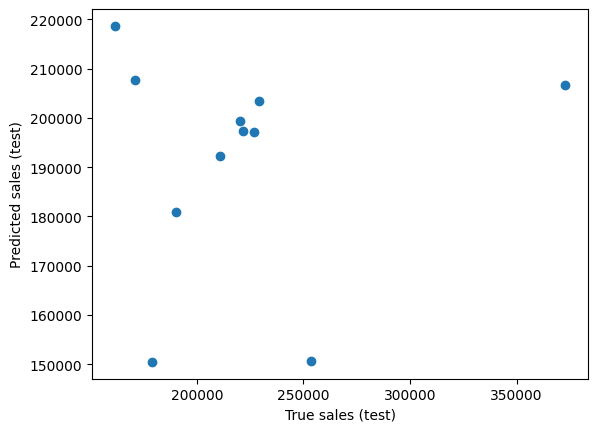

In [334]:
# lasso_model = LassoCV(n_alphas=100, random_state=10, cv=TimeSeriesSplit(test_size=12), n_jobs=8).fit(X_train_scaled, y_train_scaled.flatten())
# print("Regularisation:", lasso_model.alpha_)
lasso_model = Lasso(alpha=0.01, random_state=0).fit(X_train_scaled, y_train_scaled.flatten())

y_train_pred = sales_scaler.inverse_transform(lasso_model.predict(X_train_scaled)[:, np.newaxis])
y_test_pred = sales_scaler.inverse_transform(lasso_model.predict(X_test_scaled)[:, np.newaxis])

print("RMSE, train:", mean_squared_error(y_train_pred, y_train, squared=False))
print("RMSE, test:", mean_squared_error(y_test_pred, y_test, squared=False))

plt.scatter(y_test, y_test_pred)
plt.xlabel("True sales (test)")
plt.ylabel("Predicted sales (test)")

Text(0, 0.5, 'Importance')

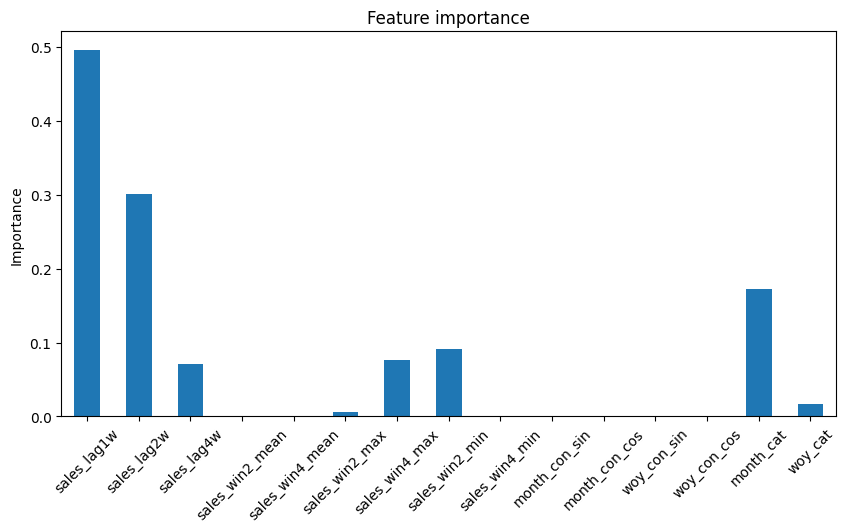

In [335]:
# Create series with feature importance.
tmp = pd.Series(abs(lasso_model.coef_.flatten()))

# Let's add the variable names.
tmp.index = X_train_scaled.columns
# Let's make a bar plot.
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")

- Scaling the feature does not improve the model
- 